In [37]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# from sklearn.preprocessing import MinMaxScaler

# MAIN VERSION

In [38]:
# Read data
df = pd.read_excel("data/riskindicators_table.xlsx", sheet_name='Clean_Index')
df['Risk Category'] = df['Risk Category'].ffill()
df = df.melt(id_vars=['Risk Category', 'Risk ID','Risk Indicator'], var_name='Company', value_name='Value')
df['Risk ID'] = df['Risk ID'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Risk Category   100 non-null    object 
 1   Risk ID         100 non-null    object 
 2   Risk Indicator  100 non-null    object 
 3   Company         100 non-null    object 
 4   Value           96 non-null     float64
dtypes: float64(1), object(4)
memory usage: 4.0+ KB


In [39]:
# scaler = MinMaxScaler()
# df['Standardized Value'] = df.groupby(['Risk Category', 'Risk Indicator'])['Value'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten() * 100)

# df

In [40]:
# Standardize the values for each indicator in each category
df['Standardized Value'] = df.groupby(['Risk Category', 'Risk Indicator'])['Value'].transform(lambda x: (x / x.mean() * 100))
df

,Risk Category,Risk ID,Risk Indicator,Company,Value,Standardized Value
0,1. Competitive behavior/practice,1.01,Valuation growth (%),Google DeepMind,0.356217,7.333166
1,1. Competitive behavior/practice,1.02,Market share (revenue),Google DeepMind,0.070000,72.913629
2,1. Competitive behavior/practice,1.03,Acceleration (yoy change in model updates freq...,Google DeepMind,3.892183,410.149312
3,1. Competitive behavior/practice,1.04,"Acquisitions - annual, count",Google DeepMind,0.000000,0.000000
4,1. Competitive behavior/practice,1.05,"Acquisitions - annual, cost",Google DeepMind,0.000000,0.000000
...,...,...,...,...,...,...
95,3. Commitment to emerging standards,3.03,Endorsement of UN Global Digital Compact,OpenAI,0.000000,NaN
96,4. Incidents,4.01,AI-related incidents,OpenAI,30.000000,180.722892
97,4. Incidents,4.02,Cybersecurity incidents (related to security/s...,OpenAI,2.000000,500.000000
98,4. Incidents,4.03,Litigation Frequency where company is defendant,OpenAI,18.000000,346.153846


In [41]:
df.to_csv("data/riskindicators_table_std.csv", index=False)

In [42]:
# Aggregate the data by 'Company' and 'Risk Category'
risk_category_df = df.groupby(['Risk Category', 'Company']).agg({
    'Standardized Value': 'mean'
}).reset_index()

risk_category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Risk Category       20 non-null     object 
 1   Company             20 non-null     object 
 2   Standardized Value  20 non-null     float64
dtypes: float64(1), object(2)
memory usage: 612.0+ bytes


In [43]:
risk_category_df

,Risk Category,Company,Standardized Value
0,1. Competitive behavior/practice,Anthropic,74.922942
1,1. Competitive behavior/practice,Google DeepMind,80.645916
2,1. Competitive behavior/practice,Meta AI,83.236355
3,1. Competitive behavior/practice,OpenAI,198.084599
4,1. Competitive behavior/practice,x.AI,33.598337
5,2. ​Compliance and Safety Practices,Anthropic,160.769767
6,2. ​Compliance and Safety Practices,Google DeepMind,82.209830
7,2. ​Compliance and Safety Practices,Meta AI,95.985547
8,2. ​Compliance and Safety Practices,OpenAI,137.691159
9,2. ​Compliance and Safety Practices,x.AI,23.343697


In [44]:
risk_category_df.to_csv("data/risk_category_std.csv", index=False)

In [45]:
# Aggregate the data by 'Company'
risk_company_df = df.groupby(['Company']).agg({
    'Standardized Value': 'mean'
}).reset_index()
risk_company_df = risk_company_df.sort_values(by='Standardized Value', ascending=True).reset_index(drop=True)
risk_company_df

,Company,Standardized Value
0,x.AI,28.602477
1,Meta AI,68.719137
2,Google DeepMind,84.977121
3,Anthropic,88.526202
4,OpenAI,214.144005


In [46]:
risk_company_df.to_csv("data/risk_company_std.csv", index=False)

In [47]:
# Sort the DataFrame by 'Standardized Value' in descending order
sorted_risk_company_df = risk_company_df.sort_values(by='Standardized Value', ascending=False)

# Create a table
table = go.Figure(data=[go.Table(
    header=dict(values=['Company', 'Risk Index'],
                fill_color='paleturquoise',
                align='center'),
    cells=dict(values=[sorted_risk_company_df['Company'], sorted_risk_company_df['Standardized Value'].map('{:.2f}'.format)],
               fill_color='lavender',
               align='center'))
])

# Update the layout
table.update_layout(
    # title=None,
    autosize=False,
    width=500,
    height=200,
    margin=dict(l=10, r=10, t=40, b=0)
)

# Show the table
table.show()

In [48]:
# Create a horizontal bar chart
fig = go.Figure(data=[
    go.Bar(
        name='Standardized Value', 
        x=risk_company_df['Standardized Value'], 
        y=risk_company_df['Company'], 
        orientation='h',
        text=risk_company_df.index + 1,  # Add rank as text
        textposition='auto'
    )
])

# Update the layout to remove x-axis and show y-axis with company names
fig.update_layout(
    # title=None,
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=True, tickmode='array', tickvals=risk_company_df.index, ticktext=risk_company_df['Company']),
    template='plotly_white'
)

fig.show()

In [49]:
# Create a list of unique risk categories
companies = risk_category_df['Company'].unique()
categories = risk_category_df['Risk Category'].unique()


# Create a radar chart
fig = go.Figure()

# Add a trace for each company
for company in companies:
    company_data = risk_category_df[risk_category_df['Company'] == company]
    fig.add_trace(go.Scatterpolar(
        r=company_data['Standardized Value'],
        theta=categories,
        connectgaps = True,
        fill='toself',
        name=company
    ))

# Update the layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 400]
        )),
    showlegend=True,
    title="Risk Index based on Category"
)

fig.show()

In [50]:
# Create a subplot with 1 row and multiple columns (one for each company)
fig = make_subplots(
    rows=1, 
    cols=len(companies), 
    subplot_titles=[f"{company}" for company in companies], 
    specs=[[{'type': 'polar'}] * len(companies)]
)

# Add a trace for each company in its respective subplot
for i, company in enumerate(companies):
    company_data = risk_category_df[risk_category_df['Company'] == company]
    company_data = company_data.replace({
        'Risk Category': {
            '1. Competitive behavior/practice': 'Behaviour',
            '2. \u200bCompliance and Safety Practices': 'Safety',
            '3. Commitment to emerging standards': 'Standards',
            '4. Incidents': 'Incident'
        }
    })
    fig.add_trace(go.Scatterpolar(
        r=company_data['Standardized Value'],
        theta=company_data['Risk Category'],
        connectgaps=True,
        fill='toself',
        name=company
    ), row=1, col=i+1)

# Adjust the position of the subplot titles
for annotation in fig['layout']['annotations']:
    annotation['y'] += 0.1  

# Update the layout
for j in range(1, len(companies) + 1):
    fig.update_layout(**{f'polar{j}': dict(
        radialaxis=dict(
            visible=True,
            range=[0, 400]
        ),
        angularaxis=dict(
            rotation=90
        ))
    })

fig.update_layout(
    width=3500,  # Adjust width as needed
    showlegend=False,
    # title="Risk Index based on Category for Each Company"
)

fig.show()


In [51]:
# from plotly.subplots import make_subplots

# # Create a subplot with 5 rows (one for each company) and 1 column
# fig = make_subplots(
#     rows=len(companies), 
#     cols=1, 
#     subplot_titles=[f"{company}" for company in companies], 
#     specs=[[{'type': 'polar'}]] * len(companies)
# )

# # Adjust the position of the subplot titles
# for annotation in fig['layout']['annotations']:
#     annotation['y'] += 0.02

# # Add a trace for each company in its respective subplot
# for i, company in enumerate(companies):
#     company_data = risk_category_df[risk_category_df['Company'] == company]
#     fig.add_trace(go.Scatterpolar(
#         r=company_data['Standardized Value'],
#         theta=company_data['Risk Category'],
#         connectgaps=True,
#         fill='toself',
#         name=company
#     ), row=i+1, col=1)

# # Update the layout
# for j in range(1, len(companies) + 1):
#     fig.update_layout(**{f'polar{j}': dict(
#         radialaxis=dict(
#             visible=True,
#             range=[0, 400]
#         ),
#         angularaxis=dict(
#             rotation=90
#         ))
#     })

# fig.update_layout(
#     height=1920,  # Adjust height as needed
#     showlegend=True,
#     # title="Risk Index based on Category for Each Company"
# )

# fig.show()


In [52]:
# Create a radar chart for each category
for category in categories:
    category_data = df[df['Risk Category'] == category]
    
    fig = go.Figure()
    
    # Add a trace for each company
    for company in companies:
        company_data = category_data[category_data['Company'] == company]
        fig.add_trace(go.Scatterpolargl(
            r=company_data['Standardized Value'],
            theta=company_data['Risk ID'],
            connectgaps=True,
            fill='toself',
            name=company
        ))

    # Update the layout to move the legend to the bottom
    fig.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.3,
            xanchor="center",
            x=0.5
        )
    )
    
    # Add annotations for Risk ID and Risk Indicator
    annotations = []
    for risk_id, risk_indicator in zip(category_data['Risk ID'].unique(), category_data['Risk Indicator'].unique()):
        annotations.append(f"{risk_id}: {risk_indicator}")
    
    # Update the layout
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 500]
            )),
        showlegend=True,
        title=f"Radar Chart for {category}",
        annotations=[dict(
            x=1.0,
            y=1.1,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<br>".join(annotations),
            align="left"
        )]
    )
    
    fig.show()

## Regressions

### Only components

In [53]:
import statsmodels.api as sm

# Pivot the data so that each company has its own row and each risk category becomes a column.
df_pivot = risk_category_df.pivot(index='Company', columns='Risk Category', values='Standardized Value')

# Rename the columns for clarity. The mapping is:
# "1. Competitive behavior/practice"  -> "Competitive"
# "2. ​Compliance and Safety Practices" -> "Safety"
# "3. Commitment to emerging standards" -> "Commitment"
# "4. Incidents"                        -> "Incidents"
rename_map = {
    "1. Competitive behavior/practice": "Competitive",
    "2. ​Compliance and Safety Practices": "Safety",
    "3. Commitment to emerging standards": "Commitment",
    "4. Incidents": "Incidents"
}
df_pivot = df_pivot.rename(columns=rename_map)

# Display the pivoted data (optional)
print(df_pivot)

# Define the dependent variable (y) and independent variables (X)
y = df_pivot['Incidents']
X = df_pivot[['Competitive', 'Safety', 'Commitment']]

# Add a constant term to the independent variables (the intercept)
X = sm.add_constant(X)

# Run the OLS regression
model = sm.OLS(y, X).fit(cov_type='HC3')

# Print the summary which includes coefficients, standard errors, and p-values.
print(model.summary())


Risk Category    Competitive      Safety  Commitment   Incidents
Company                                                         
Anthropic          74.922942  160.769767  166.666667    7.819741
Google DeepMind    80.645916   82.209830  166.666667   56.644849
Meta AI            83.236355   95.985547    0.000000   43.148556
OpenAI            198.084599  137.691159  166.666667  350.469184
x.AI               33.598337   23.343697    0.000000   41.917671
                            OLS Regression Results                            
Dep. Variable:              Incidents   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                    0.6004
Date:                Fri, 21 Feb 2025   Prob (F-statistic):              0.713
Time:                        12:21:47   Log-Likelihood:                -22.936
No. Observations:                   5   AIC:                           

c:\Users\madegde\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 5 samples were given.



In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

       feature       VIF
0        const  5.969861
1  Competitive  1.594879
2       Safety  2.203062
3   Commitment  2.009255


<Axes: xlabel='Risk Category', ylabel='Risk Category'>

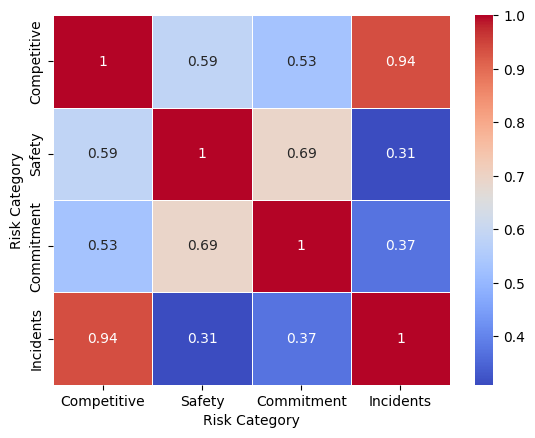

In [55]:
import seaborn as sns

# Compute the correlation matrix
corr = df_pivot.corr()

# Plot the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=.5)

# RANK VERSION

In [56]:
rank_df = df.copy()
rank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Risk Category       100 non-null    object 
 1   Risk ID             100 non-null    object 
 2   Risk Indicator      100 non-null    object 
 3   Company             100 non-null    object 
 4   Value               96 non-null     float64
 5   Standardized Value  91 non-null     float64
dtypes: float64(2), object(4)
memory usage: 4.8+ KB


In [57]:
rank_df['Rank'] = rank_df.groupby(['Risk Category', 'Risk Indicator'])['Value'].rank(ascending=True, method='min')
rank_df

,Risk Category,Risk ID,Risk Indicator,Company,Value,Standardized Value,Rank
0,1. Competitive behavior/practice,1.01,Valuation growth (%),Google DeepMind,0.356217,7.333166,1.0
1,1. Competitive behavior/practice,1.02,Market share (revenue),Google DeepMind,0.070000,72.913629,4.0
2,1. Competitive behavior/practice,1.03,Acceleration (yoy change in model updates freq...,Google DeepMind,3.892183,410.149312,4.0
3,1. Competitive behavior/practice,1.04,"Acquisitions - annual, count",Google DeepMind,0.000000,0.000000,1.0
4,1. Competitive behavior/practice,1.05,"Acquisitions - annual, cost",Google DeepMind,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...
95,3. Commitment to emerging standards,3.03,Endorsement of UN Global Digital Compact,OpenAI,0.000000,NaN,1.0
96,4. Incidents,4.01,AI-related incidents,OpenAI,30.000000,180.722892,5.0
97,4. Incidents,4.02,Cybersecurity incidents (related to security/s...,OpenAI,2.000000,500.000000,5.0
98,4. Incidents,4.03,Litigation Frequency where company is defendant,OpenAI,18.000000,346.153846,5.0


In [58]:
rank_df.to_csv("data/riskindicators_table_rank.csv", index=False)

In [59]:
# Aggregate the data by 'Company' and 'Risk Category'
rank_cat_df = rank_df.groupby(['Risk Category', 'Company']).agg({'Rank': 'sum'}).reset_index()
rank_cat_df['Rank'] = rank_cat_df.groupby('Risk Category')['Rank'].rank(ascending=True, method='min')
rank_cat_df

,Risk Category,Company,Rank
0,1. Competitive behavior/practice,Anthropic,3.0
1,1. Competitive behavior/practice,Google DeepMind,4.0
2,1. Competitive behavior/practice,Meta AI,2.0
3,1. Competitive behavior/practice,OpenAI,5.0
4,1. Competitive behavior/practice,x.AI,1.0
5,2. ​Compliance and Safety Practices,Anthropic,5.0
6,2. ​Compliance and Safety Practices,Google DeepMind,2.0
7,2. ​Compliance and Safety Practices,Meta AI,3.0
8,2. ​Compliance and Safety Practices,OpenAI,4.0
9,2. ​Compliance and Safety Practices,x.AI,1.0


In [60]:
rank_cat_df.to_csv("data/risk_category_rank.csv", index=False)

In [61]:
# Aggregate the data by 'Company'
rank_company_df = rank_cat_df.groupby(['Company']).agg({'Rank': 'sum'}).reset_index()
rank_company_df['Rank'] = rank_company_df['Rank'].rank(ascending=True, method='min')
rank_company_df = rank_company_df.sort_values(by='Rank', ascending=True).reset_index(drop=True)
rank_company_df


,Company,Rank
0,x.AI,1.0
1,Meta AI,2.0
2,Anthropic,3.0
3,Google DeepMind,4.0
4,OpenAI,5.0


In [62]:
rank_company_df.to_csv("data/risk_company_rank.csv", index=False)

In [63]:
# Create a horizontal bar chart
fig = go.Figure(data=[
    go.Bar(
        name='Rank', 
        x=rank_company_df['Rank'], 
        y=rank_company_df['Company'], 
        orientation='h',
        text=rank_company_df.index + 1,  # Add rank as text
        textposition='auto'
    )
])

# Update the layout to remove x-axis and show y-axis with company names
fig.update_layout(
    title='Rank by Company',
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=True, tickmode='array', tickvals=rank_company_df.index, ticktext=rank_company_df['Company']),
    template='plotly_white'
)

fig.show()

In [64]:
# Create a list of unique risk categories
rank_cat = rank_cat_df['Risk Category'].unique()
rank_comp = rank_cat_df['Company'].unique()

# Create a radar chart
fig = go.Figure()

# Add a trace for each company
for company in rank_comp:
    company_data = rank_cat_df[rank_cat_df['Company'] == company]
    fig.add_trace(go.Scatterpolar(
        r=company_data['Rank'],
        theta=categories,
        connectgaps=True,
        fill='toself',
        name=company
    ))

# Update the layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
        angularaxis=dict(
            rotation=90
        )
    ),
    showlegend=True,
    title="Risk Rank based on Category"
)

fig.show()

In [65]:
# Create a subplot with 1 row and multiple columns (one for each company)
fig = make_subplots(
    rows=1, 
    cols=len(rank_comp), 
    subplot_titles=[f"{company}" for company in rank_comp], 
    specs=[[{'type': 'polar'}] * len(rank_comp)]
)

# Add a trace for each company in its respective subplot
for i, company in enumerate(rank_comp):
    company_data = rank_cat_df[rank_cat_df['Company'] == company]
    company_data = company_data.replace({
        'Risk Category': {
            '1. Competitive behavior/practice': 'Behaviour',
            '2. \u200bCompliance and Safety Practices': 'Safety',
            '3. Commitment to emerging standards': 'Standards',
            '4. Incidents': 'Incident'
        }
    })
    fig.add_trace(go.Scatterpolar(
        r=company_data['Rank'],
        theta=company_data['Risk Category'],
        connectgaps=True,
        fill='toself',
        name=company
    ), row=1, col=i+1)

# Adjust the position of the subplot titles
for annotation in fig['layout']['annotations']:
    annotation['y'] += 0.1  

# Update the layout
for j in range(1, len(companies) + 1):
    fig.update_layout(**{f'polar{j}': dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
        angularaxis=dict(
            rotation=90
        ))
    })

fig.update_layout(
    width=2000,  # Adjust width as needed
    showlegend=False,
    # title="Risk Index based on Category for Each Company"
)

fig.show()


In [66]:
# Create a radar chart for each category
for category in categories:
    category_data = rank_df[rank_df['Risk Category'] == category]
    
    fig = go.Figure()
    
    # Add a trace for each company
    for company in companies:
        company_data = category_data[category_data['Company'] == company]
        fig.add_trace(go.Scatterpolargl(
            r=company_data['Rank'],
            theta=company_data['Risk ID'],
            connectgaps=True,
            fill='toself',
            name=company
        ))

    # Update the layout to move the legend to the bottom
    fig.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.3,
            xanchor="center",
            x=0.5
        )
    )
    
    # Add annotations for Risk ID and Risk Indicator
    annotations = []
    for risk_id, risk_indicator in zip(category_data['Risk ID'].unique(), category_data['Risk Indicator'].unique()):
        annotations.append(f"{risk_id}: {risk_indicator}")
    
    # Update the layout
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 5]),
        angularaxis=dict(
            rotation=90
        )),
        showlegend=True,
        title=f"Rank Chart for {category}",
        annotations=[dict(
            x=1.0,
            y=1.1,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<br>".join(annotations),
            align="left"
        )]
    )
    
    fig.show()

# EXTENDED VERSION

## Indicator Dataset

In [67]:
# Read data
data = pd.read_excel("data/riskindicators_table.xlsx", sheet_name='Clean_Index_V2')
data['Risk Category'] = data['Risk Category'].ffill()
data = data.melt(id_vars=['Risk Category', 'Risk ID','Risk Indicator'], var_name='Company', value_name='Value')
data['Risk ID'] = data['Risk ID'].astype(str)

# Standardize the values for each indicator in each category
data['Standardized Value'] = data.groupby(['Risk Category', 'Risk Indicator'])['Value'].transform(lambda x: (x / x.mean() * 100))

# Save to CSV
data.to_csv("data/riskindicators_table_ext.csv", index=False)

## Category Dataset

In [68]:
# Aggregate the data by 'Company' and 'Risk Category'
risk_category_data = data.groupby(['Risk Category', 'Company']).agg({
    'Standardized Value': 'mean'
}).reset_index()

# Save to CSV
risk_category_data.to_csv("data/risk_category_ext.csv", index=False)

## Company Dataset

In [69]:
# Aggregate the data by 'Company'
risk_company_data = data.groupby(['Company']).agg({
    'Standardized Value': 'mean'
}).reset_index()
risk_company_data = risk_company_data.sort_values(by='Standardized Value', ascending=True).reset_index(drop=True)

# Save to CSV
risk_company_data.to_csv("data/risk_company_ext.csv", index=False)

# FULL VERSION

In [70]:
# Read data
data = pd.read_excel("data/riskindicators_table.xlsx", sheet_name='Clean_Index_V3')
data['Risk Category'] = data['Risk Category'].ffill()
data = data.melt(id_vars=['Risk Category', 'Risk ID','Risk Indicator'], var_name='Company', value_name='Value')
data['Risk ID'] = data['Risk ID'].astype(str)

# Standardize the values for each indicator in each category
data['Standardized Value'] = data.groupby(['Risk Category', 'Risk Indicator'])['Value'].transform(lambda x: (x / x.mean() * 100))

# Save to CSV
data.to_csv("data/riskindicators_table_full.csv", index=False)

In [71]:
# Aggregate the data by 'Company' and 'Risk Category'
risk_category_data = data.groupby(['Risk Category', 'Company']).agg({
    'Standardized Value': 'mean'
}).reset_index()

# Save to CSV
risk_category_data.to_csv("data/risk_category_full.csv", index=False)

In [72]:
# Aggregate the data by 'Company'
risk_company_data = data.groupby(['Company']).agg({
    'Standardized Value': 'mean'
}).reset_index()
risk_company_data = risk_company_data.sort_values(by='Standardized Value', ascending=True).reset_index(drop=True)

# Save to CSV
risk_company_data.to_csv("data/risk_company_full.csv", index=False)